# Proyecto 13: ANalisis y Prediccion de Demanda de taxis

## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM (RMSE) en el conjunto de prueba no debe ser superior a 48.

## 1. Descarga y preparación de datos

Se descagará el dataset original y se preprocesará.


In [2]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

current_working_directory = Path.cwd()
project_root = current_working_directory.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.data.make_dataset import download_and_save, load_and_resample_taxi_data
from src.visualization.visualize import plot_time_series, plot_seasonal_decompose



### Descarga de datos

In [3]:
url_dataset = 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv'
raw_data_path = '../data/raw/taxi.csv'
processed_data_path = '../data/processed/resampled_taxi_data.parquet'

In [4]:
# Ejecutar función de descarga
download_and_save(url_dataset, filename='taxi.csv')

El archivo taxi.csv ya existe en D:\projects\TripleTen\sprint_13\data\raw. Descarga cancelada.


### Carga y Remuestreo de Datos
Como se nos solicita entrenar al modelo para predecir en una hora, se remuestrará a 1 cada, sumando el número de órdenes para obtener el total por horas.


In [5]:
# Carga y remuestreo del DataFrame
# Esta función también verifica que el índice esté ordenado y guarda los datos remuestreados
df_resampled = load_and_resample_taxi_data(raw_data_path, processed_data_path)

Cargando datos desde: ../data/raw/taxi.csv
Realizando remuestreo a frecuencia horaria...
Remuestreo completado.
Datos remuestreados guardados en: ../data/processed/resampled_taxi_data.parquet


In [6]:
# Muestra inicial del DataFrame remuestreado
print("Primeras 10 filas del DataFrame remuestreado:")
print(df_resampled.head(10))

Primeras 10 filas del DataFrame remuestreado:
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6
2018-03-01 06:00:00          12
2018-03-01 07:00:00          15
2018-03-01 08:00:00          34
2018-03-01 09:00:00          69


In [7]:
print("Información del DataFrame remuestreado:")
df_resampled.info()

Información del DataFrame remuestreado:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Los datos están completos (no hay NaNs visibles después del remuestreo en las primeras filas), el tipo de datos es correcto y se encuentran ordenados de manera ascendente.

## 2. Análisis Exploratorio de Datos (EDA)

In [8]:
data_eda = df_resampled.copy()

### Visualización de datos

Gráfico guardado en: ../reports/figures/demand_rolling_stats.png


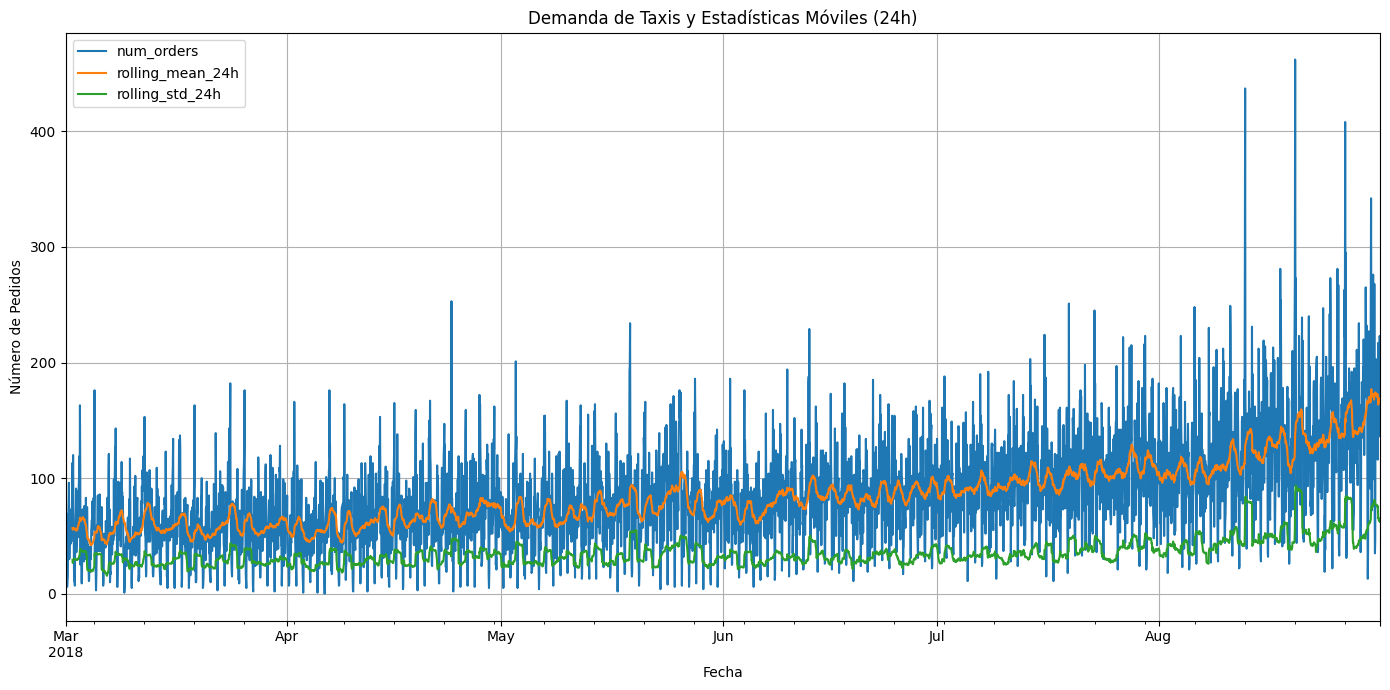

In [10]:
data_eda['rolling_mean_24h'] = data_eda['num_orders'].rolling(24).mean()
data_eda['rolling_std_24h'] = data_eda['num_orders'].rolling(24).std()

plot_time_series(
    data_eda[['num_orders', 'rolling_mean_24h', 'rolling_std_24h']],
    title='Demanda de Taxis y Estadísticas Móviles (24h)',
    ylabel='Número de Pedidos',
    save_path='../reports/figures/demand_rolling_stats.png'
)

Del gráfico se puede apreciar que, si bien la franja de números de viajes es relativamente ancha con una tendencia al aumento, con el gráfico de la media móvil se refleja de mejor manera esta tendencia. Por otro lado, la desviación estándar se mantiene relativamente constante, por lo que se puede asumir que el gráfico es medianamente estacionario.

### Análisis de Estacionalidad y Tendencia

Gráfico de descomposición guardado en: ../reports/figures/seasonal_decompose_global.png


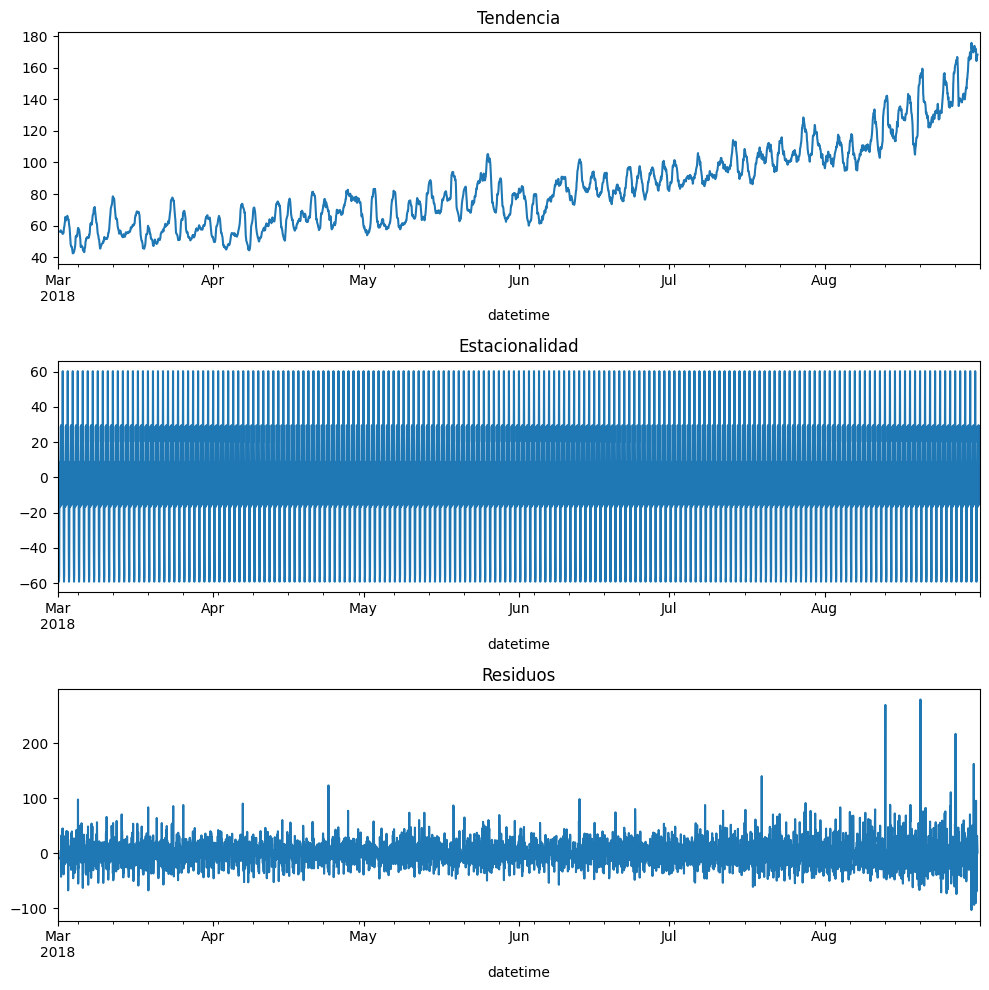

In [11]:
decomposed_global = seasonal_decompose(df_resampled)
plot_seasonal_decompose(decomposed_global, save_path='../reports/figures/seasonal_decompose_global.png')

Se puede apreciar una tendencia al alza a lo largo de todo el periodo. En cuanto a la estacionalidad, es difícil notar el patrón a nivel global debido a la escala, aunque se puede notar que aproximadamente hay 4-5 franjas más oscuras que se repiten por mes, por lo que se analizará en un rango más corto (ej. 10-15 días) para ver patrones diarios/semanales.


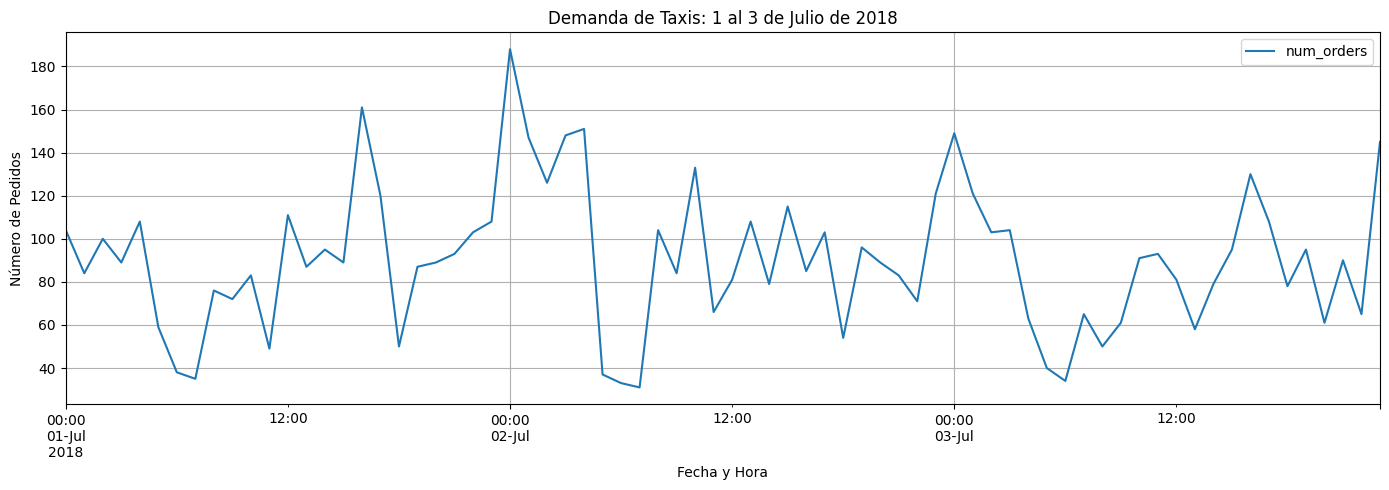

In [13]:
# Visualización de un período más corto
df_resampled['2018-07-01':'2018-07-03'].plot(figsize=(14, 5))
plt.title('Demanda de Taxis: 1 al 3 de Julio de 2018')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Pedidos')
plt.grid(True)
plt.tight_layout()
plt.savefig('../reports/figures/demand_july_01_03.png')
plt.show()

Gráfico de descomposición guardado en: ../reports/figures/seasonal_decompose_short_period.png


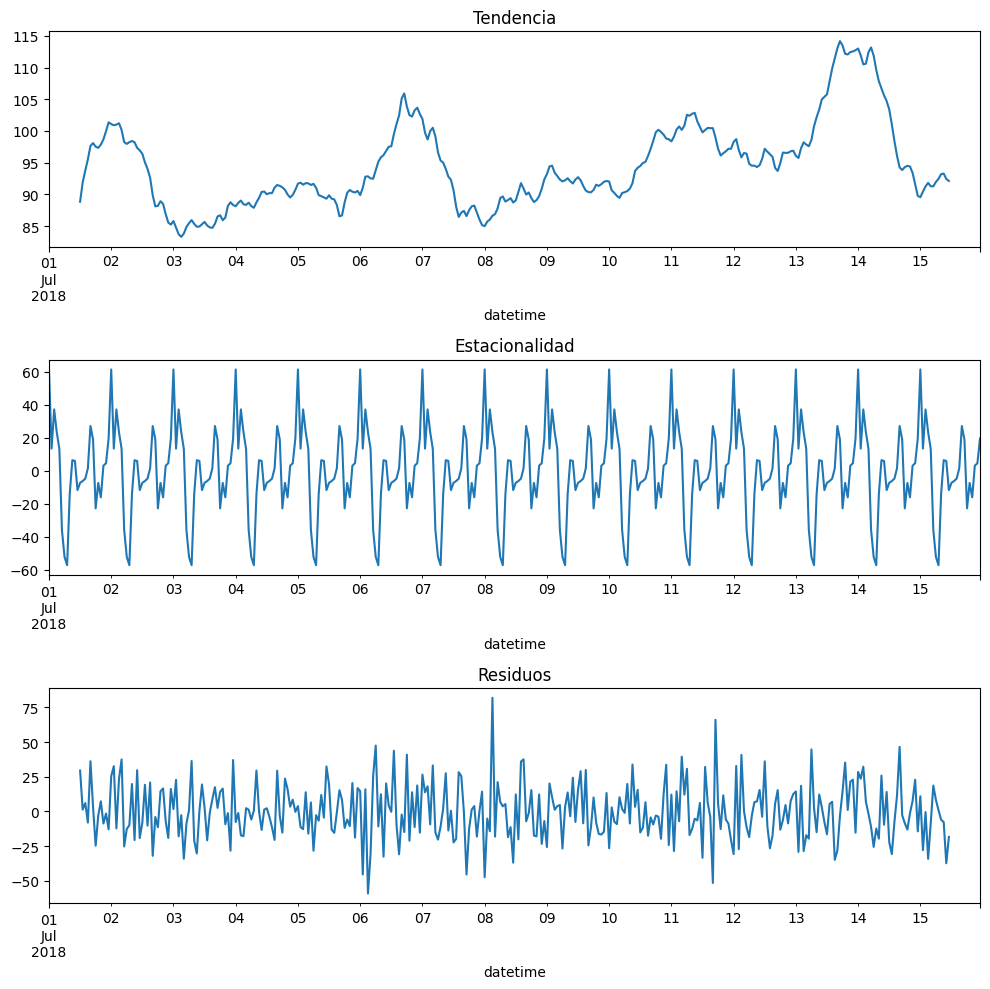

In [14]:
# Análisis de estacionalidad y tendencia en un rango de 15 días (ej. 1 al 15 de julio)
decomposed_short = seasonal_decompose(df_resampled['2018-07-01':'2018-07-15'])
plot_seasonal_decompose(decomposed_short, save_path='../reports/figures/seasonal_decompose_short_period.png')


El gráfico muestra los datos desde el día Domingo 1 de Julio hasta el día domingo 15 de Julio. Aquí se logra apreciar de mejor manera que hay patrones que se repiten semanalmente, los cuales parecen repetirse los fines de semana con mayor demanda, y patrones diarios (picos y valles dentro de cada día).

## Conclusiones del Análisis Exploratorio

* **Tendencia:** Existe una clara tendencia al alza en el número de pedidos de taxis a lo largo del tiempo, lo que sugiere un crecimiento en la demanda.
* **Estacionalidad:** Se observa una estacionalidad semanal y diaria distintiva. La demanda varía significativamente a lo largo de las horas del día y los días de la semana, con posibles picos en fines de semana o ciertas horas del día.
* **Estacionariedad:** Aunque hay una tendencia, la desviación estándar móvil se mantiene relativamente constante, lo que indica que las fluctuaciones alrededor de la media pueden ser predecibles.